# Batch GP Baseline Plots for SkyPatrol LCs

This notebook runs `per_camera_gp_baseline` for all `data/skypatrol2/*.csv` files using `df_plot.plot_many_lc`. Adjust the hyperparameters below as needed.



In [1]:
from pathlib import Path

from df_plot import plot_lc_with_residuals, SKYPATROL_CSV_PATHS
from lc_baseline import per_camera_gp_baseline

# Where to save outputs
OUT_DIR = Path("lc_plots/skypatrol_gp")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# GP hyperparameters (tune as desired)
gp_kwargs = {
    "sigma": 0.08,   # mag amplitude; lower to smooth more
    "rho": 150.0,    # characteristic timescale (days); higher to smooth more
    "q": 0.7,        # damping; <1 reduces oscillation
    "jitter": 0.006, # mag floor; set >= median photometric error
}

# Plot params
PLOT_KW = {
    "out_dir": OUT_DIR,
    "out_format": "pdf",  # change to "png" if you prefer
    "show": False,         # set True to display inline (slower)
}

print("Output directory:", OUT_DIR.resolve())


Output directory: /Users/calder/Documents/asassn-variability/calder/lc_plots/skypatrol_gp


# Batch GP baseline plots (SkyPatrol)

Use `plot_lc_with_residuals` with `per_camera_gp_baseline` to process all `data/skypatrol2/*.csv` files.


In [2]:
from pathlib import Path

from df_plot import plot_lc_with_residuals, SKYPATROL_CSV_PATHS
from lc_baseline import per_camera_gp_baseline

# Output directory
OUT_DIR = Path("lc_plots/skypatrol_gp")
OUT_DIR.mkdir(parents=True, exist_ok=True)

# GP hyperparameters
gp_kwargs = {
    "sigma": 0.08,   # mag amplitude; lower to smooth more
    "rho": 150.0,    # characteristic timescale (days); higher to smooth more
    "q": 0.7,        # damping; <1 reduces oscillation
    "jitter": 0.006, # mag floor; set >= median photometric error
}

results = plot_lc_with_residuals(
    dat_paths=SKYPATROL_CSV_PATHS,
    baseline_func=per_camera_gp_baseline,
    baseline_kwargs=gp_kwargs,
    out_path=OUT_DIR,
    out_format="pdf",
    show=False,
)

print(f"Saved {len(results)} files to {OUT_DIR.resolve()}")
for r in results[:5]:
    print("-", r)
if len(results) > 5:
    print("...", len(results) - 5, "more")


Saved 28 files to /Users/calder/Documents/asassn-variability/calder/lc_plots/skypatrol_gp
- lc_plots/skypatrol_gp/120259184943-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/223339338105-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/231929175915-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/25770019815-light-curves_per_camera_gp_baseline_residuals.pdf
- lc_plots/skypatrol_gp/266288137752-light-curves_per_camera_gp_baseline_residuals.pdf
... 23 more


## Baseline function smoke tests

Quick synthetic checks to ensure each baseline variant returns `baseline`, `resid`, and `sigma_resid` with finite values on a small synthetic dataset.


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

N = 40
jd = np.arange(N, dtype=float)
trend = 0.002 * jd
noise = np.random.normal(0, 0.01, N)
mag = 15.0 + trend + 0.1 * np.sin(jd / 6.0) + noise
err = np.full(N, 0.02, dtype=float)
cam = np.where(jd < N / 2, "A", "B")

df_synth = pd.DataFrame(
    {
        "JD": jd,
        "mag": mag,
        "error": err,
        "camera#": cam,
    }
)

def check_baseline_output(df, name):
    required = {"baseline", "resid", "sigma_resid"}
    assert required.issubset(df.columns), f"{name}: missing columns"
    finite_baseline = np.isfinite(df["baseline"])
    finite_resid = np.isfinite(df["resid"])
    finite_sigma = np.isfinite(df["sigma_resid"])
    assert finite_baseline.any(), f"{name}: baseline all-NaN"
    assert finite_resid.any(), f"{name}: resid all-NaN"
    assert finite_sigma.any(), f"{name}: sigma_resid all-NaN"
    print(f"{name}: ok ({finite_baseline.sum()} finite baselines)")


In [4]:
from lc_baseline import (
    global_mean_baseline,
    global_median_baseline,
    global_rolling_median_baseline,
    global_rolling_mean_baseline,
    per_camera_mean_baseline,
    per_camera_median_baseline,
    per_camera_trend_baseline,
    per_camera_gp_baseline,
)

tests = [
    ("global_mean_baseline", global_mean_baseline, {}),
    ("global_median_baseline", global_median_baseline, {}),
    ("global_rolling_median_baseline", global_rolling_median_baseline, {"days": 40.0, "min_points": 5}),
    ("global_rolling_mean_baseline", global_rolling_mean_baseline, {"days": 20.0, "min_points": 5}),
    ("per_camera_mean_baseline", per_camera_mean_baseline, {}),
    ("per_camera_median_baseline", per_camera_median_baseline, {"days": 40.0, "min_points": 5}),
    (
        "per_camera_trend_baseline",
        per_camera_trend_baseline,
        {"days_short": 40.0, "days_long": 80.0, "min_points": 5, "last_window_guard": 10.0},
    ),
    (
        "per_camera_gp_baseline",
        per_camera_gp_baseline,
        {"sigma": 0.05, "rho": 20.0, "q": 0.7, "jitter": 0.01},
    ),
]

for name, func, kwargs in tests:
    df_out = func(df_synth, **kwargs)
    check_baseline_output(df_out, name)



global_mean_baseline: ok (40 finite baselines)
global_median_baseline: ok (40 finite baselines)
global_rolling_median_baseline: ok (36 finite baselines)
global_rolling_mean_baseline: ok (36 finite baselines)
per_camera_mean_baseline: ok (40 finite baselines)
per_camera_median_baseline: ok (32 finite baselines)
per_camera_trend_baseline: ok (32 finite baselines)
per_camera_gp_baseline: ok (40 finite baselines)


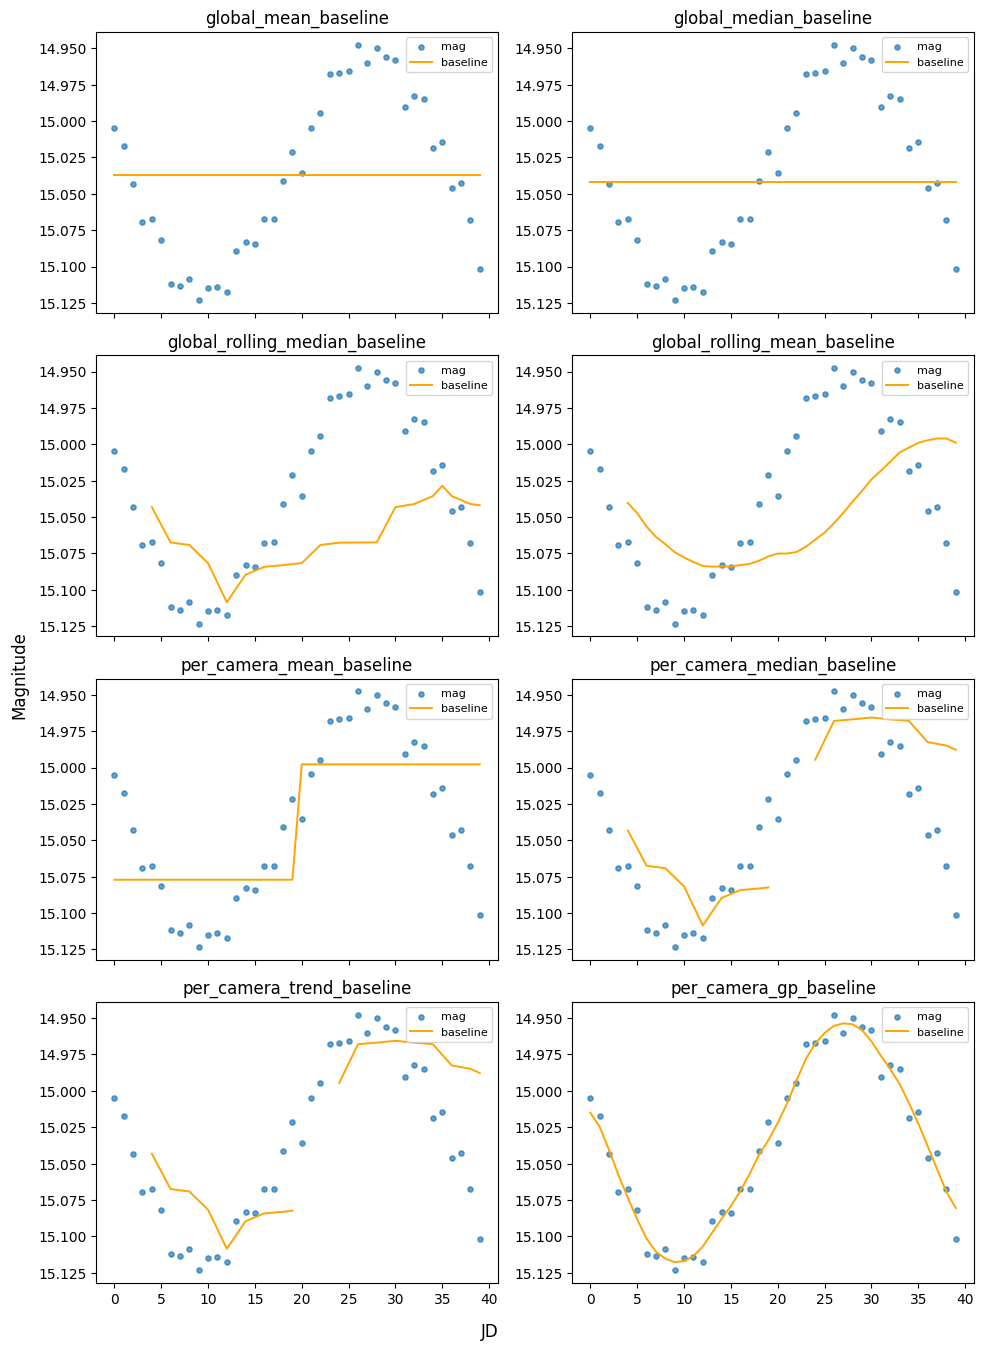

In [5]:
import matplotlib.pyplot as plt

n = len(tests)
ncols = 2
nrows = (n + ncols - 1) // ncols
fig, axes = plt.subplots(nrows, ncols, figsize=(10, 3.4 * nrows), sharex=True)
axes = axes.flatten()

for ax, (name, func, kwargs) in zip(axes, tests):
    df_out = func(df_synth, **kwargs)
    ax.scatter(df_out["JD"], df_out["mag"], s=14, alpha=0.7, label="mag")
    ax.plot(df_out["JD"], df_out["baseline"], color="orange", lw=1.4, label="baseline")
    ax.set_title(name)
    ax.invert_yaxis()
    ax.legend(loc="best", fontsize=8)

for ax in axes[n:]:
    ax.axis("off")

fig.supxlabel("JD")
fig.supylabel("Magnitude")
plt.tight_layout()
plt.show()



## Batch baselines on SkyPatrol data

Run every baseline function over all `SKYPATROL_CSV_PATHS` and write plots to `lc_plots/skypatrol_all_baselines/<baseline_tag>`. Set `show=False` to avoid inline rendering; adjust kwargs if you want to tune smoothing.


In [ ]:
from pathlib import Path

from df_plot import plot_lc_with_residuals, SKYPATROL_CSV_PATHS

baseline_runs = [
    ("global_mean", global_mean_baseline, {}),
    ("global_median", global_median_baseline, {}),
    ("global_roll_median", global_rolling_median_baseline, {"days": 400.0, "min_points": 15}),
    ("global_roll_mean", global_rolling_mean_baseline, {"days": 400.0, "min_points": 15}),
    ("per_cam_mean", per_camera_mean_baseline, {}),
    ("per_cam_median", per_camera_median_baseline, {"days": 400.0, "min_points": 15}),
    (
        "per_cam_trend",
        per_camera_trend_baseline,
        {"days_short": 200.0, "days_long": 800.0, "min_points": 12, "last_window_guard": 120.0},
    ),
    (
        "per_cam_gp",
        per_camera_gp_baseline,
        {"sigma": 0.08, "rho": 150.0, "q": 0.7, "jitter": 0.006},
    ),
]

OUT_ROOT = Path("lc_plots/skypatrol_all_baselines")
OUT_ROOT.mkdir(parents=True, exist_ok=True)

results_summary = {}
for tag, func, kwargs in baseline_runs:
    out_dir = OUT_ROOT / tag
    out_dir.mkdir(parents=True, exist_ok=True)
    print(f"Running {tag} -> {out_dir} ...")
    files = plot_lc_with_residuals(
        dat_paths=SKYPATROL_CSV_PATHS,
        baseline_func=func,
        baseline_kwargs=kwargs,
        out_path=out_dir,
        out_format="pdf",
        show=False,
        baseline_tag=tag,
    )
    results_summary[tag] = len(files) if files else 0
    print(f"  saved {results_summary[tag]} files")

print("Done. Counts per baseline:")
for tag, count in results_summary.items():
    print(f"- {tag}: {count}")

